<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/Classifica%C3%A7%C3%A3o_Fashion_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

sklearn: 1.2.2
tensorflow: 2.13.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

print ( gpus )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_model = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
    model_path = "keras_model.h5"
    scaler_path = "standard_scaler.joblib"

### Amostra FASHION MNIST

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:10000], X_train_full[10000:]
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]

tf.random.set_seed(42)
np.random.seed(42)

print ( X_train.shape )
print ( X_valid.shape )
print ( X_test.shape )

4422102/4422102 [==============================] - 0s 0us/step
(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [5]:
X_mean = X_train.mean( axis=0 )
X_std = X_train.std( axis=0 )
X_train_scaled = ( X_train - X_mean ) / X_std
X_valid_scaled = ( X_valid - X_mean ) / X_std
X_test_scaled  = ( X_test - X_mean ) / X_std
X_train_scaled[10]

array([[-0.00714939, -0.02259701, -0.04749068, -0.04039468, -0.05683006,
        -0.07010959, -0.09760359, -0.15513164, -0.23893762, -0.37952352,
        -0.57053077, -0.694674  , -0.75900494, -0.74973597, -0.74937949,
        -0.7751858 , -0.75745513, -0.64652364, -0.50360013, -0.31979054,
        -0.20224307, -0.13951541, -0.10889008, -0.09206532, -0.06849855,
        -0.0507646 , -0.03324326, -0.01443135],
       [-0.01230748, -0.0168835 , -0.03319486, -0.05559106, -0.07714261,
        -0.13124202, -0.24326328, -0.36492659, -0.48893735, -0.6445122 ,
        -0.8337121 , -1.00353902, -1.09301419, -1.0837614 , -1.06800491,
        -1.10748471, -1.08937986, -0.93927296, -0.77985187, -0.59368043,
        -0.44115158, -0.31720835, -0.20840274, -0.14927912, -0.11911465,
        -0.09064336, -0.05802733, -0.02866097],
       [-0.0156428 , -0.02551341, -0.04573707, -0.07322531, -0.12932057,
        -0.26949551, -0.40463   , -0.50344952, -0.63127809, -0.8226511 ,
        -0.99415394, -1.0723

In [6]:
print ( y_train )

[8 7 6 ... 3 0 5]


In [7]:
import keras.utils

number_of_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, number_of_classes)
y_valid_cat = keras.utils.to_categorical(y_valid, number_of_classes)
y_test_cat = keras.utils.to_categorical(y_test, number_of_classes)

idx=1000
y_train[idx], y_train_cat[idx]

(8, array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32))

1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] Trouser


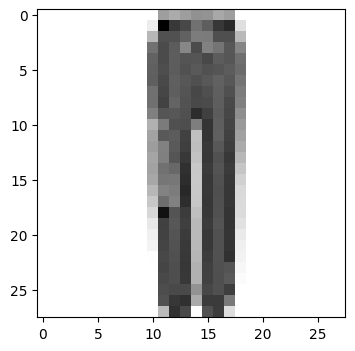

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

idx = 1000
print ( y_valid[ idx ], y_valid_cat[ idx ], class_names[ y_valid[ idx ] ] )
# print ( X_valid_scaled[ idx ] )

fig = plt.figure( figsize=(4,4) )
plt.imshow( X_valid[ idx ], cmap='binary' )

### Treinamento

In [9]:
shuffle_index = np.random.permutation( 50000 )
X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]

### Definição do modelo

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D

class Model:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def __call__(self, dropout):

        input_shape = self.input_shape
        learning_rate = self.learning_rate

        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Dropout rate: {}".format(dropout) )

        model = Sequential()

        model.add( Conv2D( 32, (3, 3), input_shape=input_shape ) )
        model.add( Activation('relu') )
        BatchNormalization( axis=-1 )
        model.add( Conv2D( 32, (3, 3) ) )
        model.add( Activation('relu') )
        model.add( MaxPooling2D( pool_size=(2,2) ) )

        BatchNormalization( axis=-1 )
        model.add( Conv2D( 64,(3, 3) ) )
        model.add( Activation('relu') )
        BatchNormalization( axis=-1 )
        model.add( Conv2D(64, (3, 3) ) )
        model.add( Activation('relu') )
        model.add( MaxPooling2D( pool_size=(2,2) ) )

        model.add(Flatten())
        # Fully connected layer

        BatchNormalization()
        model.add( Dense(512) )
        model.add( Activation('relu') )
        BatchNormalization()
        model.add( Dropout( dropout ) )
        model.add( Dense(10) )

        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))

        optimizer = keras.optimizers.Adam( learning_rate=learning_rate )
        # model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        return model

def build_model(input_shape, learning_rate=5e-4, dropout=0.20 ):
    build_fn_ = Model( input_shape=input_shape, learning_rate=learning_rate )
    return build_fn_( dropout )


### Callbacks

In [11]:
class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )

exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

In [12]:
import os

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )

    return callbacks_


In [13]:
# Trainign batch size
batch_size = 32
# Number of training epochs
epochs = 10
# Learning rate
lr = 5e-4
callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )

model = build_model( (28,28,1), learning_rate=lr, dropout=0.20 )
model.summary()

Building model with:
Input shape: (28, 28, 1)
Learning rate: 0.0005
Dropout rate: 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 

In [14]:
history = model.fit( X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )

Epoch 1/10
1563/1563 [==============================] - 20s 6ms/step - loss: 0.6764 - accuracy: 0.7511 - val_loss: 0.6029 - val_accuracy: 0.7891 - lr: 0.0100
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5179 - accuracy: 0.8072 - val_loss: 0.4529 - val_accuracy: 0.8322 - lr: 0.0079
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.4544 - accuracy: 0.8315 - val_loss: 0.4348 - val_accuracy: 0.8434 - lr: 0.0063
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4135 - accuracy: 0.8449 - val_loss: 0.4105 - val_accuracy: 0.8465 - lr: 0.0050
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3832 - accuracy: 0.8565 - val_loss: 0.3886 - val_accuracy: 0.8557 - lr: 0.0040
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3483 - accuracy: 0.8685 - val_loss: 0.3645 - val_accuracy: 0.8671 - lr: 0.0032
Epoch 7/10
1563/1563 [==============================] - 

In [15]:
model.evaluate( X_valid_scaled, y_valid )

313/313 [==============================] - 1s 3ms/step - loss: 0.3344 - accuracy: 0.8799


[0.33440372347831726, 0.8798999786376953]

In [16]:
score = model.evaluate( X_test_scaled, y_test )
print()
print('Test accuracy: ', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3483 - accuracy: 0.8759

Test accuracy:  0.8758999705314636


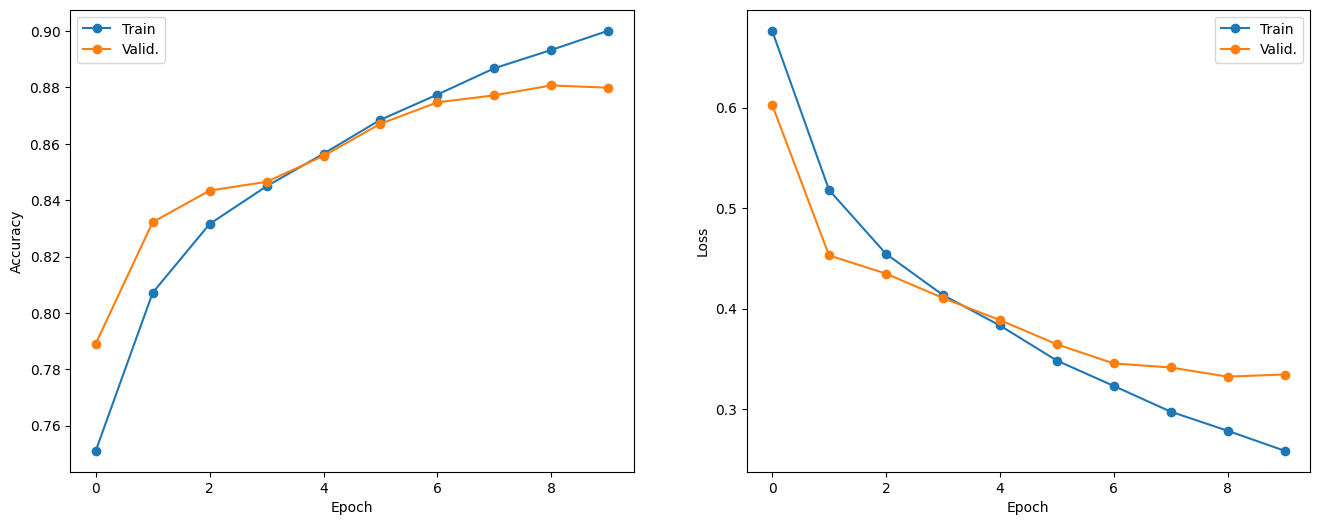

In [17]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend( loc='best' )
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend( loc='best' )

In [18]:
y_test_proba = model.predict( X_test_scaled )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

313/313 [==============================] - 1s 2ms/step
[[3.95304567e-10 9.36243596e-13 1.14419420e-13 ... 3.29157076e-04
  2.11157705e-08 9.99647856e-01]
 [3.19552601e-05 1.76830758e-10 9.94982600e-01 ... 1.53252135e-18
  1.34330967e-05 4.21987149e-17]
 [1.71576295e-13 9.99998927e-01 1.12443508e-17 ... 3.48126444e-26
  9.55972801e-12 1.19173858e-24]
 ...
 [3.26490307e-10 1.25337546e-10 7.25466909e-12 ... 2.02342686e-14
  1.00000000e+00 1.18014070e-16]
 [2.38493079e-11 9.99998927e-01 1.39156155e-14 ... 5.14595263e-20
  3.61942919e-12 5.24489385e-17]
 [5.86244417e-03 1.13640681e-06 9.87258740e-04 ... 2.06997748e-02
  3.73471975e-02 5.66905597e-04]]
[9 2 1 ... 8 1 5]


In [19]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.8759


1241
T-shirt/top (0): 153
Trouser (1): 30
Pullover (2): 180
Dress (3): 102
Coat (4): 256
Sandal (5): 39
Shirt (6): 343
Sneaker (7): 46
Bag (8): 39
Ankle boot (9): 53


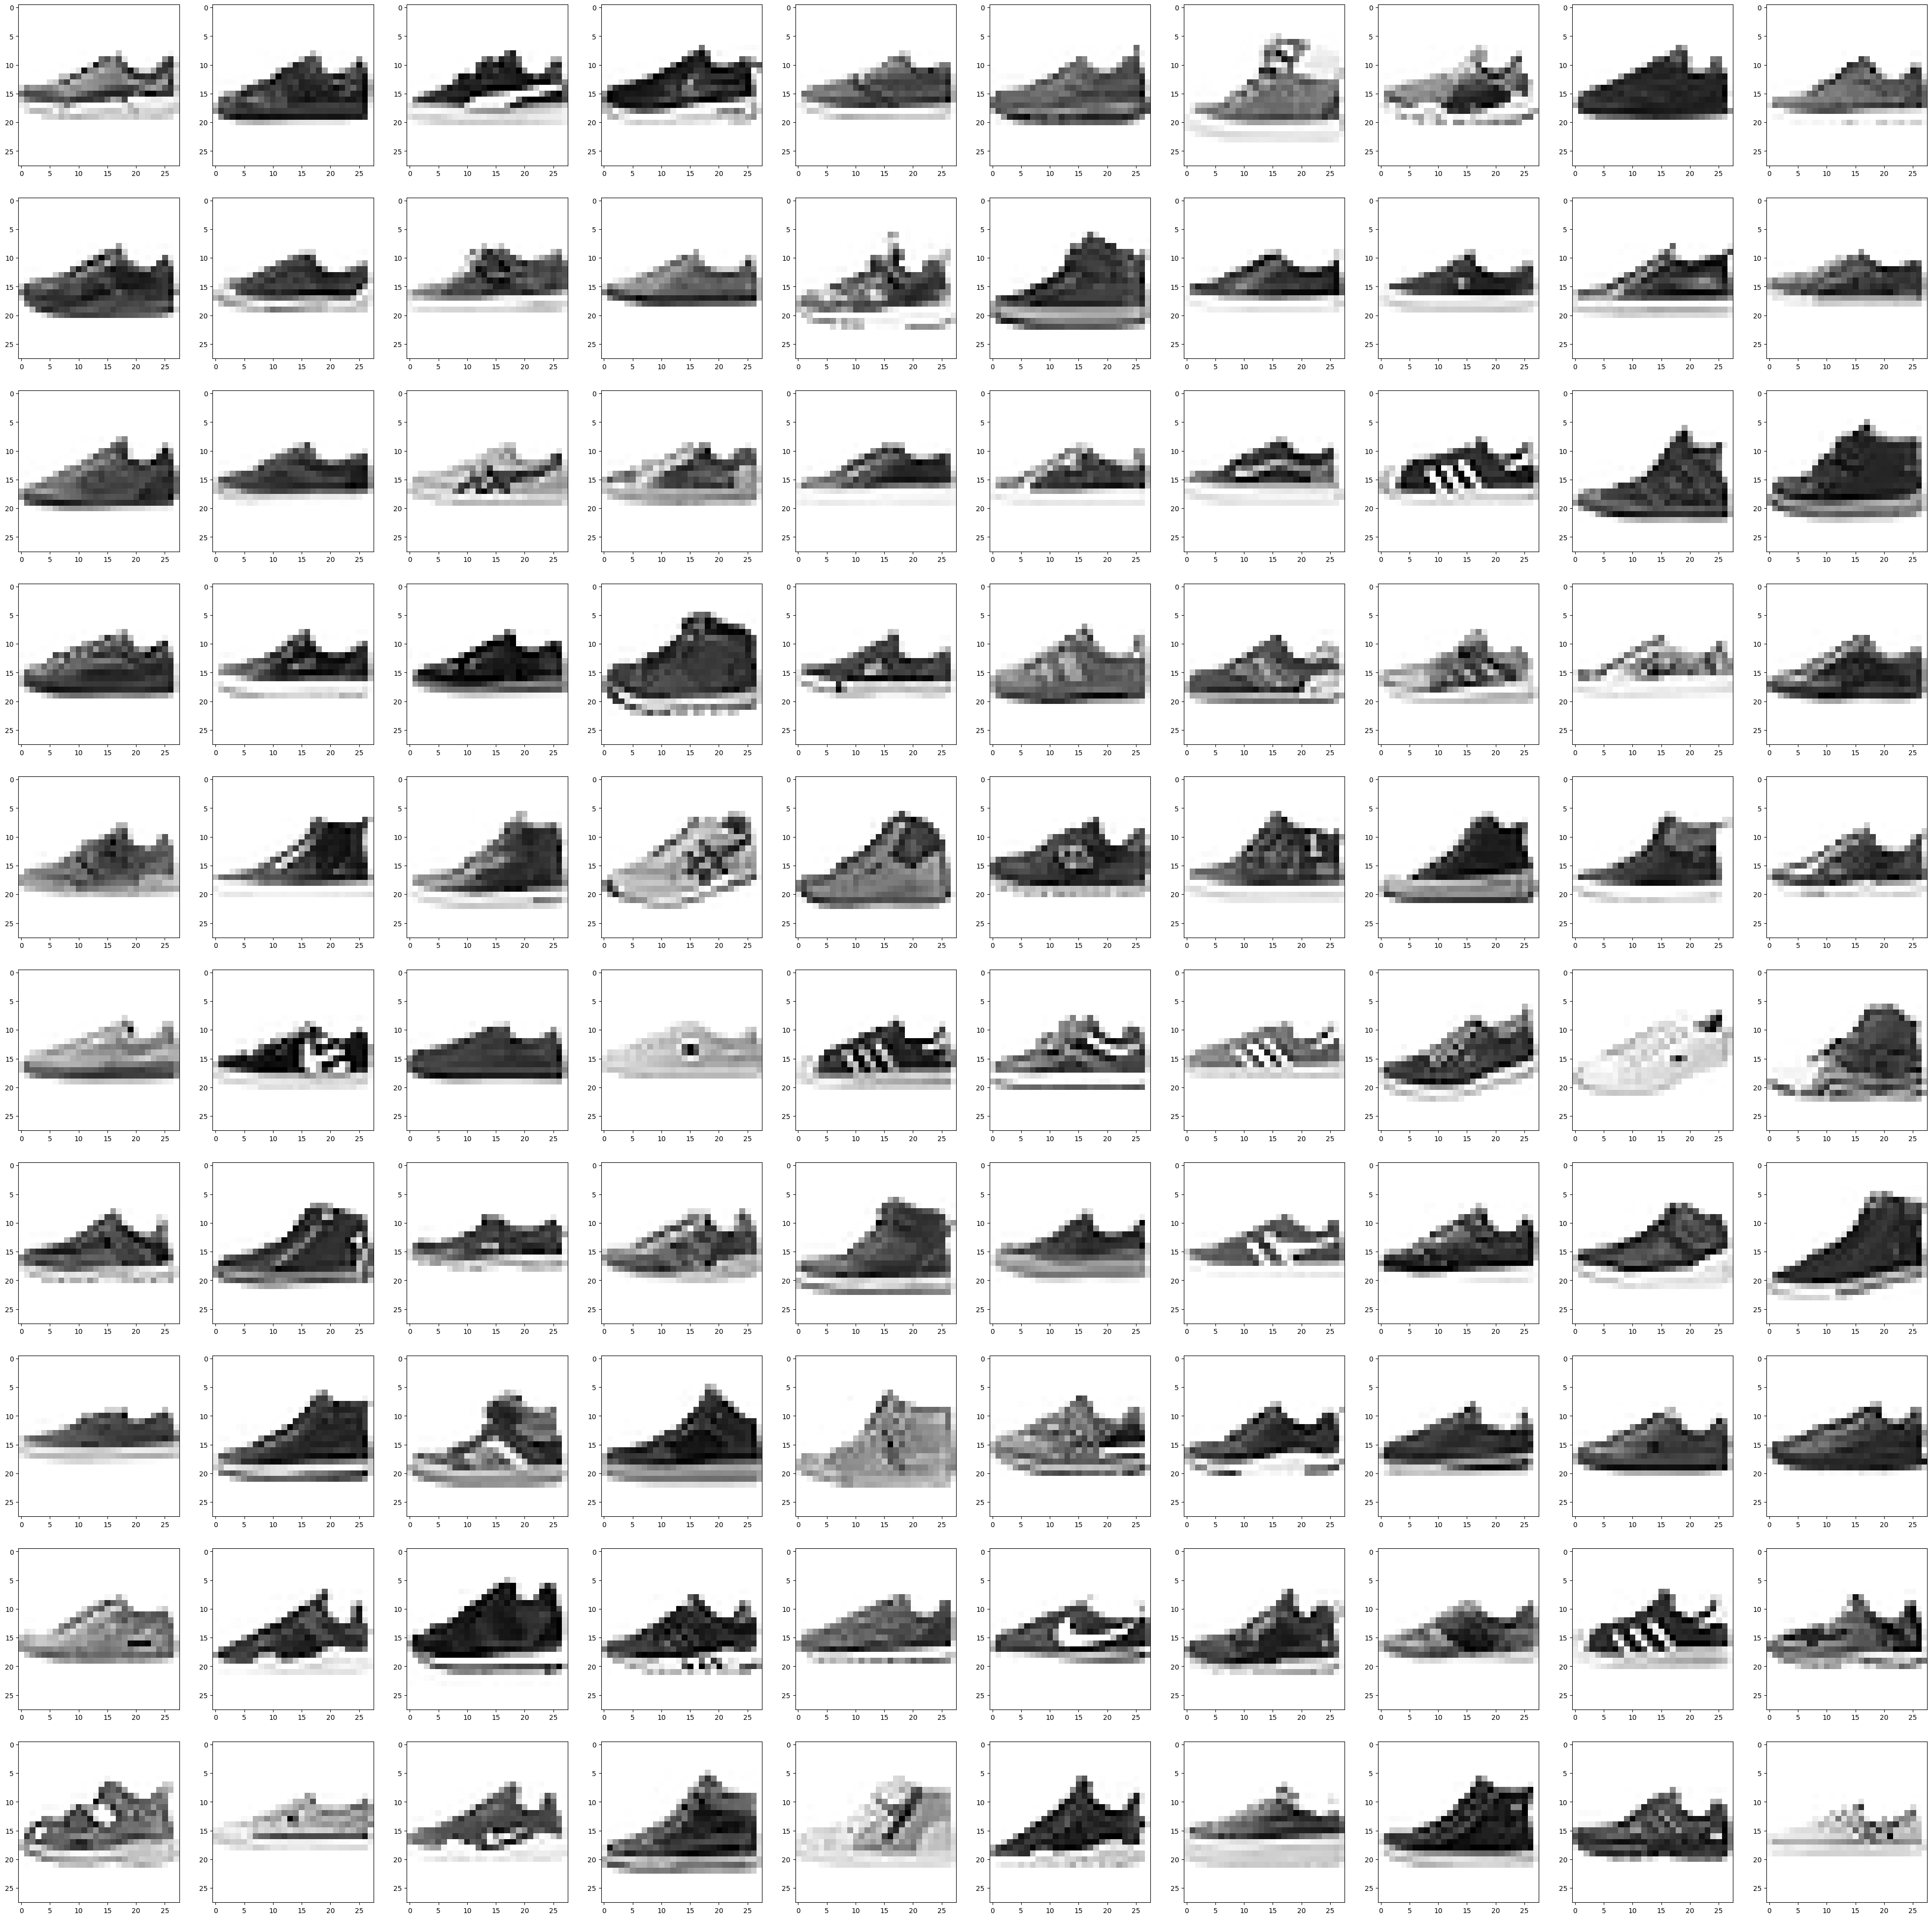

In [20]:
def plot_images( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break

        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ], cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{} ({}): {}".format( class_names[label_], label_, np.sum( msk__ ) ) )

msk_pred_Sneaker_ = y_test_pred == 7

# plot_images( X_test[ msk_error_ ], 100 )
plot_images( X_test[ msk_pred_Sneaker_ ], 100 )